In [1]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import random
import json
import os
import tqdm
import time
from data_loader import test_dataloader,noise_test_dataloader,two_class_test_dataloader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from utils import AverageMeter, save_checkpoint, accuracy, adjust_learning_rate,get_network

In [2]:
fix_seed = 2024
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

In [3]:
#数据根路径(1,2,3,expand)
dataset_id='expand'
#数据集选择 ('1d','GADF','MFCC_40_72','STFT_72_72','mfcc',stft)
dataset_choose='mfcc'
noise='None'
#模型选择 (cnn1d,resnet1d,vgg1d,alexnet1d,cnn2d,googlenet,googlenet1d,alexnet,resnet18,resnet50,vit,cct,vit_small,swin,mult_cnn,vgg11,
    #         cnn_capsnet,res_capsnet,seres_capsnet,res18_capsnet,cbam_capsnet,cbamres_capsnet,cnn_capsnet_reconstruct,res_capsnet_reconstruct
    #         cct_capsnet,gra_capsnet)
model_choose='cct_capsnet'
checkpoint_basic_path='/root/autodl-tmp/Python projects/my_project/checkpoint'
checkpoint_name='model_best_mfcc_cct_capsnet_32_0.0001_0.0001_3_43'
# 模型权重保存的路径  
checkpoint_path = checkpoint_basic_path+'/{}/'.format(dataset_id)+checkpoint_name+'.pth'

#数据路径  
base_path='/root/autodl-tmp/Python projects/Dataset/'+'{}'.format(dataset_id)

# Load the checkpoint from file
checkpoint = torch.load(checkpoint_path)
#类别数
Num_classes=3
classes = ['natural','ep','ss']#['natural','non_natural','noise']#['natural','non_natural']## 


/tmp/ipykernel_2469/51130266.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [4]:
    #应该是模型的测试部分  模型训练完再改
    # optionlly resume from a checkpoint 加载权重？？？
    # if resume==1:
    #     if os.path.isfile(args.resume):
    #         print("=> loading checkpoint '{}'".format(args.resume))
    #         checkpoint = torch.load(args.resume)
    #         args.start_epoch = checkpoint['epoch']
    #         best_prec1 = checkpoint['best_prec1']
    #         model.load_state_dict(checkpoint['state_dict'])
    #         optimizer.load_state_dict(checkpoint['optimizer'])
    #         print("=> loaded checkpoint '{}' (epoch {})".format(args.resume, checkpoint['epoch']))
    # else:
    #     print("=> no checkpoint found at '{}'".format(args.resume))
    # if evaluate==1:
    #     validate(val_loader, model, criterion, print_freq)
    #     return

In [5]:
#定义模型
model = get_network(dataset_choose=dataset_choose,net=model_choose,Num_classes=Num_classes)
model.cuda()
# Load the model's state dictionary
model.load_state_dict(checkpoint['state_dict'])
model.eval()


CapsNet(
  (cctLayer): CompactTransformer(
    (to_patch_embedding): ConvEmbed(
      (conv_layers): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace=True)
        (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): ReLU(inplace=True)
        (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (6): Rearrange('b d h w -> b (h w) d')
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (transformer): Transformer(
      (layers): ModuleList(
        (0-11): 12 x ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (to_qkv): Linear(in_features=64, out_features=2304, bias=False)
              (to_out): Sequential(
                (0): Linear

In [6]:
#数据集加载     
if Num_classes ==3:
    if dataset_choose=='1d':
        test_loader =test_dataloader(natural_test_path=base_path+'/tensor_dataset/natural_test_dataset.pt',
                                        ep_test_path=base_path+'/tensor_dataset/ep_test_dataset.pt',
                                        ss_test_path=base_path+'/tensor_dataset/ss_test_dataset.pt',
                                        )
        natural_id_list = torch.load(base_path+'/tensor_dataset/natural_test_id.pt')
        ep_id = torch.load(base_path+'/tensor_dataset/ep_test_id.pt')
        ss_id = torch.load(base_path+'/tensor_dataset/ss_test_id.pt')                            
        non_natural_id_list = ep_id+ss_id
    elif dataset_id =='expand' and dataset_choose== 'mfcc' and noise=='None':
        test_loader =test_dataloader(natural_test_path=base_path+'/mfcc/natural_test_MFCC.pt',
                                        ep_test_path=base_path+'/mfcc/ep_test_MFCC.pt',
                                        ss_test_path=base_path+'/mfcc/ss_test_MFCC.pt',
                                        )
        natural_id_list = torch.load(base_path+'/natural_test_id.pt')
        ep_id = torch.load(base_path+'/ep_test_id.pt')
        ss_id = torch.load(base_path+'/ss_test_id.pt')   
        non_natural_id_list = ep_id+ss_id 
    elif dataset_id =='expand' and dataset_choose== 'stft' and noise=='None':
        test_loader =test_dataloader(natural_test_path=base_path+'/stft/natural_test_STFT.pt',
                                        ep_test_path=base_path+'/stft/ep_test_STFT.pt',
                                        ss_test_path=base_path+'/stft/ss_test_STFT.pt',
                                        )
        natural_id_list = torch.load(base_path+'/natural_test_id.pt')
        ep_id = torch.load(base_path+'/ep_test_id.pt')
        ss_id = torch.load(base_path+'/ss_test_id.pt')   
        non_natural_id_list = ep_id+ss_id 
    elif dataset_id =='expand' and dataset_choose== 'mfcc' and noise=='True':
        test_loader =noise_test_dataloader(natural_test_path=base_path+'/mfcc/natural_test_MFCC.pt',
                                        ep_test_path=base_path+'/mfcc/ep_test_MFCC.pt',
                                        ss_test_path=base_path+'/mfcc/ss_test_MFCC.pt',
                                        noise_test_path=base_path+'/mfcc/noise_test_MFCC.pt'
                                        )
        natural_id_list = torch.load(base_path+'/natural_test_id.pt')
        ep_id = torch.load(base_path+'/ep_test_id.pt')
        ss_id = torch.load(base_path+'/ss_test_id.pt')   
        non_natural_id_list = ep_id+ss_id 
    elif dataset_id =='expand' and dataset_choose== 'stft' and noise=='True':
        test_loader =noise_test_dataloader(natural_test_path=base_path+'/stft/natural_test_STFT.pt',
                                        ep_test_path=base_path+'/stft/ep_test_STFT.pt',
                                        ss_test_path=base_path+'/stft/ss_test_STFT.pt',
                                        noise_test_path=base_path+'/stft/noise_test_STFT.pt'
                                        )
        natural_id_list = torch.load(base_path+'/natural_test_id.pt')
        ep_id = torch.load(base_path+'/ep_test_id.pt')
        ss_id = torch.load(base_path+'/ss_test_id.pt')   
        non_natural_id_list = ep_id+ss_id 
    elif dataset_choose=='STFT':
        test_loader =test_dataloader(natural_test_path=base_path+'/processed_data/STFT/natural_test_STFT.pt',
                                        ep_test_path=base_path+'/processed_data/STFT/ep_test_STFT.pt',
                                        ss_test_path=base_path+'/processed_data/STFT/ss_test_STFT.pt',
                                        )
        natural_id_list = torch.load(base_path+'/tensor_dataset/natural_test_id.pt')
        ep_id = torch.load(base_path+'/tensor_dataset/ep_test_id.pt')
        ss_id = torch.load(base_path+'/tensor_dataset/ss_test_id.pt')                            
        non_natural_id_list = ep_id+ss_id
    elif dataset_choose=='MFCC'or dataset_choose == 'MFCC_40_72':
        test_loader =test_dataloader(natural_test_path=base_path+'/processed_data/MFCC_40_72/natural_test_MFCC.pt',
                                        ep_test_path=base_path+'/processed_data/MFCC_40_72/ep_test_MFCC.pt',
                                        ss_test_path=base_path+'/processed_data/MFCC_40_72/ss_test_MFCC.pt',
                                        )
        natural_id_list = torch.load(base_path+'/tensor_dataset/natural_test_id.pt')
        ep_id = torch.load(base_path+'/tensor_dataset/ep_test_id.pt')
        ss_id = torch.load(base_path+'/tensor_dataset/ss_test_id.pt')                            
        non_natural_id_list = ep_id+ss_id
    elif dataset_choose=='STFT_72_72':
        test_loader =test_dataloader(natural_test_path=base_path+'/processed_data/STFT_72_72/natural_test_STFT.pt',
                                        ep_test_path=base_path+'/processed_data/STFT_72_72/ep_test_STFT.pt',
                                        ss_test_path=base_path+'/processed_data/STFT_72_72/ss_test_STFT.pt',
                                        )
        natural_id_list = torch.load(base_path+'/tensor_dataset/natural_test_id.pt')
        ep_id = torch.load(base_path+'/tensor_dataset/ep_test_id.pt')
        ss_id = torch.load(base_path+'/tensor_dataset/ss_test_id.pt')                            
        non_natural_id_list = ep_id+ss_id

elif Num_classes ==2:
    if dataset_id =='expand' and dataset_choose== 'MFCC_40_72':
        test_loader =two_class_test_dataloader(natural_test_path=base_path+'/processed_data/MFCC_40_72/natural_test_MFCC.pt',
                                        ep_test_path=base_path+'/processed_data/MFCC_40_72/ep_test_MFCC.pt',
                                        ss_test_path=base_path+'/processed_data/MFCC_40_72/ss_test_MFCC.pt',
                                        )
        natural_id_list = torch.load(base_path+'/tensor_dataset/natural_test_id.pt')
        ep_id = torch.load(base_path+'/tensor_dataset/ep_test_id.pt')
        ss_id = torch.load(base_path+'/tensor_dataset/ss_test_id.pt')   
        non_natural_id_list = ep_id+ss_id 
    if dataset_id =='expand' and dataset_choose== 'STFT_72_72':
        test_loader =two_class_test_dataloader(natural_test_path=base_path+'/processed_data/STFT_72_72/natural_test_STFT.pt',
                                        ep_test_path=base_path+'/processed_data/STFT_72_72/ep_test_STFT.pt',
                                        ss_test_path=base_path+'/processed_data/STFT_72_72/ss_test_STFT.pt',
                                        )
        natural_id_list = torch.load(base_path+'/tensor_dataset/natural_test_id.pt')
        ep_id = torch.load(base_path+'/tensor_dataset/ep_test_id.pt')
        ss_id = torch.load(base_path+'/tensor_dataset/ss_test_id.pt')   
        non_natural_id_list = ep_id+ss_id 
    if dataset_id =='expand' and dataset_choose== '1d':
        test_loader =two_class_test_dataloader(natural_test_path=base_path+'/tensor_dataset/natural_test_dataset.pt',
                                        ep_test_path=base_path+'/tensor_dataset/ep_test_dataset.pt',
                                        ss_test_path=base_path+'/tensor_dataset/ss_test_dataset.pt',
                                        )
        natural_id_list = torch.load(base_path+'/tensor_dataset/natural_test_id.pt')
        ep_id = torch.load(base_path+'/tensor_dataset/ep_test_id.pt')
        ss_id = torch.load(base_path+'/tensor_dataset/ss_test_id.pt')   
        non_natural_id_list = ep_id+ss_id 
    if dataset_id =='3' and dataset_choose== '1d':
        test_loader =two_class_test_dataloader(natural_test_path=base_path+'/tensor_dataset/natural_test_dataset.pt',
                                        ep_test_path=base_path+'/tensor_dataset/ep_test_dataset.pt',
                                        ss_test_path=base_path+'/tensor_dataset/ss_test_dataset.pt',
                                        )
        natural_id_list = torch.load(base_path+'/tensor_dataset/natural_test_id.pt')
        ep_id = torch.load(base_path+'/tensor_dataset/ep_test_id.pt')
        ss_id = torch.load(base_path+'/tensor_dataset/ss_test_id.pt')   
        non_natural_id_list = ep_id+ss_id 
    if dataset_id =='3' and dataset_choose== 'MFCC_40_72':
        test_loader =two_class_test_dataloader(natural_test_path=base_path+'/processed_data/MFCC_40_72/natural_test_MFCC.pt',
                                        ep_test_path=base_path+'/processed_data/MFCC_40_72/ep_test_MFCC.pt',
                                        ss_test_path=base_path+'/processed_data/MFCC_40_72/ss_test_MFCC.pt',
                                        )
        natural_id_list = torch.load(base_path+'/tensor_dataset/natural_test_id.pt')
        ep_id = torch.load(base_path+'/tensor_dataset/ep_test_id.pt')
        ss_id = torch.load(base_path+'/tensor_dataset/ss_test_id.pt')   
        non_natural_id_list = ep_id+ss_id 
    if dataset_id =='3' and dataset_choose== 'STFT_72_72':
        test_loader =two_class_test_dataloader(natural_test_path=base_path+'/processed_data/STFT_72_72/natural_test_STFT.pt',
                                        ep_test_path=base_path+'/processed_data/STFT_72_72/ep_test_STFT.pt',
                                        ss_test_path=base_path+'/processed_data/STFT_72_72/ss_test_STFT.pt',
                                        )
        natural_id_list = torch.load(base_path+'/tensor_dataset/natural_test_id.pt')
        ep_id = torch.load(base_path+'/tensor_dataset/ep_test_id.pt')
        ss_id = torch.load(base_path+'/tensor_dataset/ss_test_id.pt')   
        non_natural_id_list = ep_id+ss_id 
    

/root/autodl-tmp/Python projects/my_project/data_loader.py:326: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_natural_test = torch.load(natural_test_path)
/root/autod

In [7]:
def get_positions(string_list):
    positions_dict = {}
    positions_list = []

    for i, string in enumerate(string_list):
        if string not in positions_dict:
            positions_dict[string] = [i]
        else:
            positions_dict[string].append(i)

    for key, value in positions_dict.items():
        positions_list.append((key, value))

    return positions_list

def select(id_list,json_file_path,mode):
    selected_list=[]
    positions_list = []
    if mode=='information':#感觉还要完善
        json_file = json.load(open(json_file_path, 'r'))
        for i in id_list:
            information = json_file[i]
            #检查 'Pg_dist' 是否是非空字符串并且可以转换为浮点数
            if 'Pg_dist' in information and information['Pg_dist'] and information['Pg_dist'].replace('.', '', 1).isdigit():
                #筛选波形 指定特定特点的波形进行测试
                if float(information['Pg_dist']) >100:
                    selected_list.append(i)
                    positions_list.append(id_list.index(i))
    elif mode=='event':
        for j in id_list :
            key_correct = str(j).split('_')
            key = key_correct[0]   
            selected_list.append(key)
        positions_list = get_positions(selected_list)
        
    return selected_list,positions_list


In [8]:
natural_json_path='/root/autodl-tmp/DiTing2.0/CENC_DiTingv2_natural_earthquake.json'
non_natural_json_path='/root/autodl-tmp/DiTing2.0/CENC_DiTingv2_non_natural_earthquake.json'

Mode='event'#[information,event]

natural_selected_list,natural_positions_list=select(natural_id_list,natural_json_path,mode=Mode)
non_natural_selected_list,non_natural_positions_list=select(non_natural_id_list,non_natural_json_path,mode=Mode)
if Mode=='information':
    non_natural_positions_list = [x + len(natural_id_list)  for x in non_natural_positions_list]
    positions_list=natural_positions_list+non_natural_positions_list
elif Mode=='event':
    non_natural_positions_list = [(item[0], [x + len(natural_id_list) for x in item[1]]) for item in non_natural_positions_list]
    positions_list=natural_positions_list+non_natural_positions_list

In [9]:
Total_Pred=[]
Total_Target=[]
if Mode=='information':
    # 选择指定的批次（索引从0开始）
    for i, (input, target) in enumerate(test_loader):
        # 检查当前批次的索引是否在列表中
        if i in positions_list:
            input = input.cuda().to(torch.float32)#torch.Size([1, 3, 3000])
            target = target.cuda().to(torch.long)

            # compute output
            output= model(input)
            value,pred=torch.max(output,1)
            # print('预测概率:{},预测下标:{},预测结果:{}'.format(value,pred,classes[pred]))
            # print('target:{},实际类别:{}'.format(target,classes[target]))
            # Check if the prediction is correct
            Total_Pred.append(pred.tolist())
            Total_Target.append(target.tolist())
    # 使用numpy.squeeze去除维度为1的维度
    Total_Pred = np.squeeze(Total_Pred).tolist()
    Total_Target = np.squeeze(Total_Target).tolist()
elif Mode=='event':
    # 计算成功集合的数量
    successful_sets = 0
    for index, item in enumerate(positions_list):########后期换成positions_list
        Pred=[]
        Target=[]
        # 选择指定的批次（索引从0开始）
        for i, (input, target) in enumerate(test_loader):
            # 检查当前批次的索引是否在列表中
            if i in item[1]:
                input = input.cuda().to(torch.float32)#torch.Size([1, 3, 3000])
                #删除第一个维度  [1, 1, 3, 39, 24]
                #input = torch.squeeze(input, dim=0)
                target = target.cuda().to(torch.long)
                # compute output
                output= model(input)
                value,pred=torch.max(output,1)
                Pred.append(pred.tolist())
                Target.append(target.tolist())
        # 使用numpy.squeeze去除维度为1的维度
        Pred = np.squeeze(Pred).tolist()
        Target = np.squeeze(Target).tolist()
        # 计算准确率
        accuracy = accuracy_score(Target, Pred)
        # print('{}准确率: {:.2%}'.format(item[0],accuracy))

        # 如果准确率大于0.5，则认为是成功的集合
        if accuracy > 0.5:
            successful_sets += 1
        
        Total_Pred.append(Pred)
        Total_Target.append(Target)
    Total_Pred = sum(Total_Pred, [])
    Total_Target = sum(Total_Target, [])
    # 计算整体准确率
    Total_accuracy = accuracy_score(Total_Target, Total_Pred)
    print('准确率: {:.2%}'.format(Total_accuracy))
    # 计算多台站准确率
    vote_accuracy = successful_sets / len(positions_list)########后期换成positions_list
    print(f"多台站投票准确率: {vote_accuracy}")


/root/autodl-tmp/Python projects/my_project/models/cct_capsnet.py:184: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(self.b)
/root/autodl-tmp/Python projects/my_project/models/cct_capsnet.py:194: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(b_batch.view(-1, output_caps)).view(-1, input_caps, output_caps, 1)
/root/autodl-tmp/Python projects/my_project/models/cct_capsnet.py:184: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(self.b)
/root/autodl-tmp/Python projects/my_project/models/cct_capsnet.py:194: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(b_batch.view(-1, output_caps)).view(-1, input_caps, output_caps, 1)
/root/autodl-tmp

准确率: 89.73%
多台站投票准确率: 0.9706190975865687


In [10]:
# 计算准确率
accuracy = accuracy_score(Total_Target, Total_Pred)
print('准确率: {:.2%}'.format(accuracy))

# 计算精确率
precision = precision_score(Total_Target, Total_Pred, average='weighted')  # 'weighted' for multiclass problems
print('精确率: {:.2%}'.format(precision))

# 计算召回率
recall = recall_score(Total_Target, Total_Pred, average='weighted')  # 'weighted' for multiclass problems
print('召回率: {:.2%}'.format(recall))

# 计算 F1-score
f1 = f1_score(Total_Target, Total_Pred, average='weighted')  # 'weighted' for multiclass problems
print('F1-score: {:.2%}'.format(f1))

准确率: 89.73%
精确率: 89.75%
召回率: 89.73%
F1-score: 89.73%


In [11]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    # 添加颜色条
    colorbar = plt.colorbar()
    colorbar.ax.tick_params(labelsize=20)  # 设置颜色条的字体大小

    if target_names is not None:
        #plt.colorbar()
        #plt.imshow(data, cmap=cmap, vmin=0, vmax=1) 
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=20)
        plt.yticks(tick_marks, target_names, fontsize=20)

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # [mwen]

    thresh = cm.max() / 2 # [mwen]
    thresh_norm = cm_norm.max() / 1.5 # [mwen]
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm_norm[i, j]) + "\n{:,}".format(cm[i, j]), # [mwen]
                     horizontalalignment="center", verticalalignment="center", fontsize=20,
                     color="white" if cm_norm[i, j] > thresh_norm else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",fontsize=20,
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=20, color='darkblue') # fontweight='bold'
    plt.xlabel('Predicted label\nAccuracy: {:.2%}; Precision: {:.2%}; Recall: {:.2%}; F1-score: {:.2%}\n Voting accuracy:{:.2%}'.format(accuracy, precision, recall, f1, vote_accuracy), fontsize=16, color='darkblue')
    # 保存图像为矢量图，指定保存路径
    plt.savefig('/root/autodl-tmp/test_result/'+'{}/'.format(dataset_id)+'{}'.format(checkpoint_name)+'.svg', format='svg', dpi=300)
    plt.show()

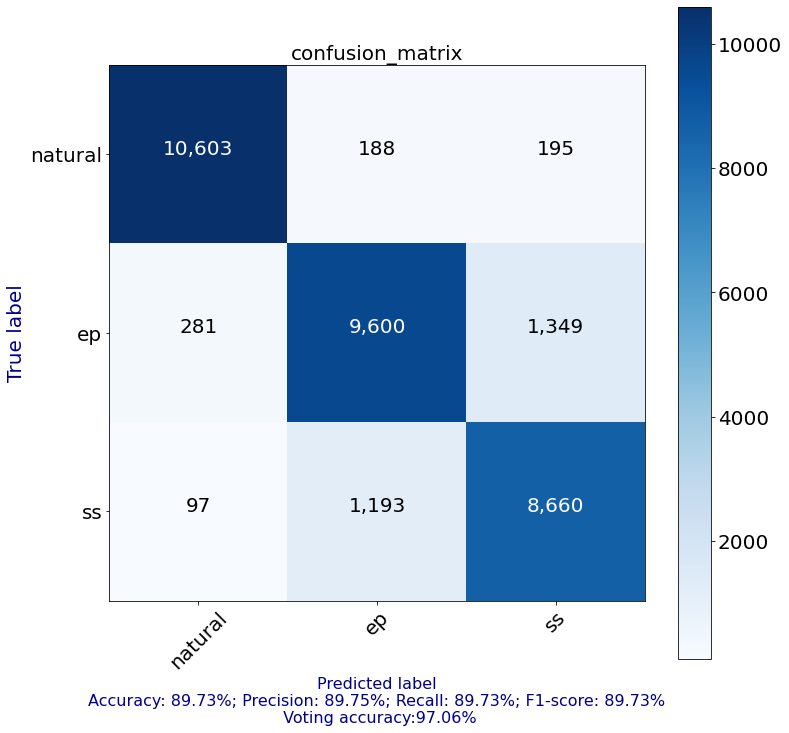

In [12]:
#画混淆矩阵
cm = confusion_matrix(Total_Target, Total_Pred)
plot_confusion_matrix(cm, target_names=classes, title='confusion_matrix')
